In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline
import numpy as np
import matplotlib
import torch
from torchvision import datasets, transforms


Populating the interactive namespace from numpy and matplotlib


Завантажимо дані

In [4]:
train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_labels = train_dataset.train_labels.numpy()
train_data = train_dataset.train_data.numpy()

train_data = train_data.reshape(train_data.shape[0], -1)

C:\Users\User\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\User\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


Кожна картинка зображується у вигляді послідовності з 0 та 1 (тобто кожен піксель зводиться або до чорного або до білого), і вважається, що пікселі згенеровані на основі випробування Бернуллі

In [5]:
def binarize(X):
    X = X/255

    binary_X = (X > 0.5).astype(float)
                     
    return binary_X

bin_train_data = binarize(train_data)

Як відрізняються оригінальні зображення MNIST від бінаризованих

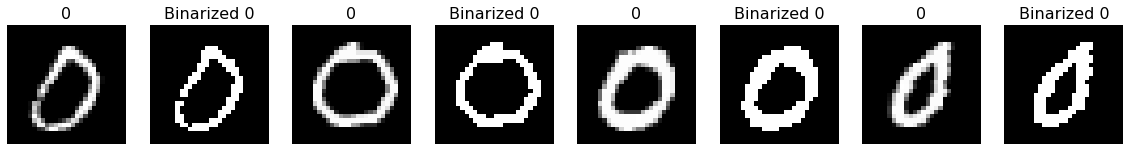

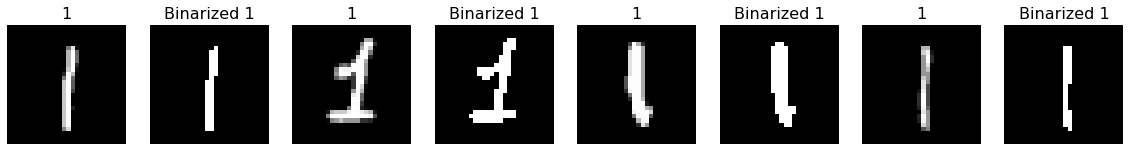

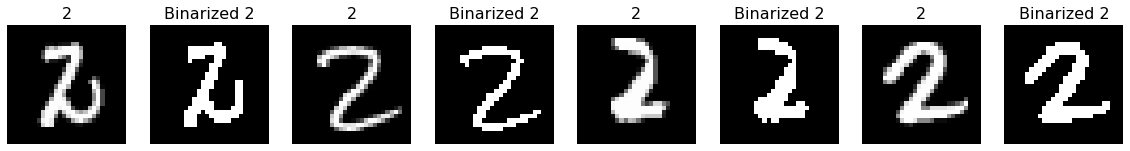

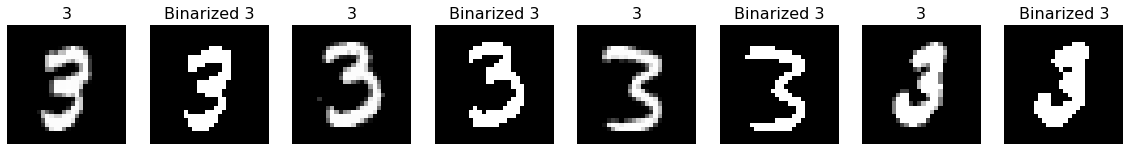

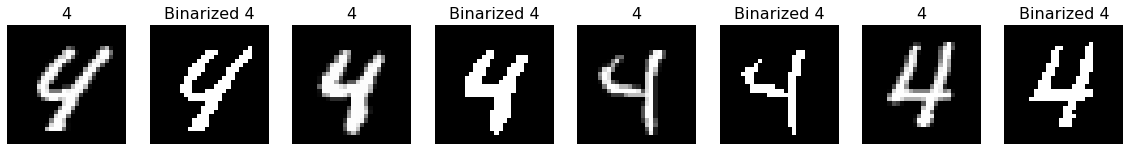

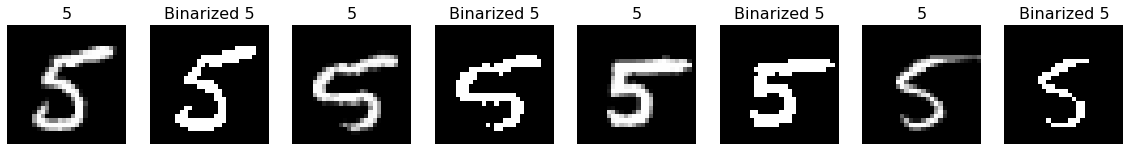

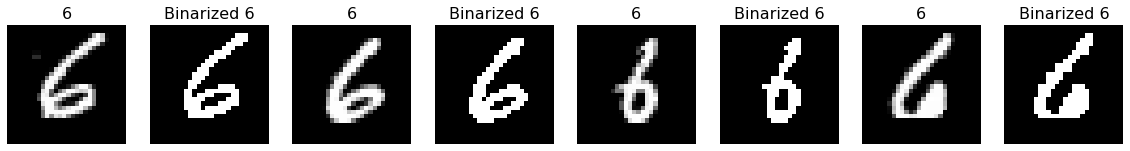

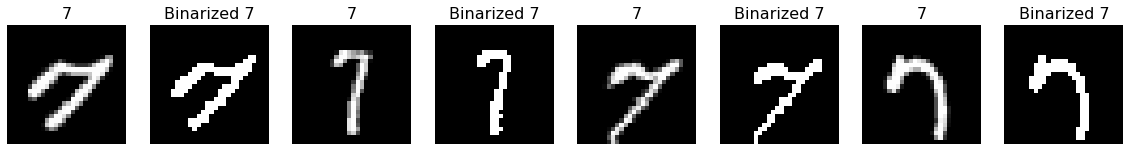

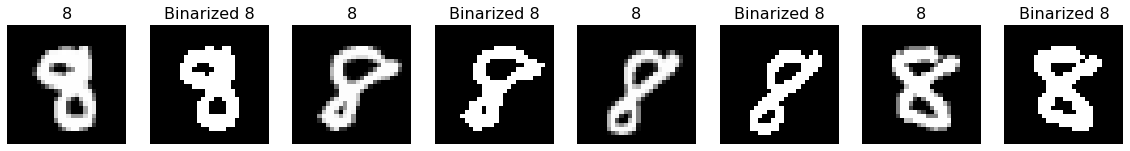

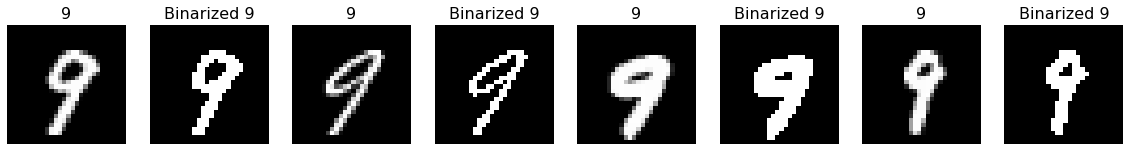

In [6]:
def visualize_digit(digit, n_samples=4):
    idxs = np.random.choice(np.where(train_labels == digit)[0], n_samples)
    fig, ax = plt.subplots(nrows=1, ncols=2*n_samples, figsize=(20, 20))

    i=0
    for idx in idxs:
        img = train_data[idx].reshape(28, 28)
        bin_img = binarize(img)
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(str(digit), fontsize=16)
        ax[i].axis('off')
        ax[i+1].imshow(bin_img, cmap='gray')
        ax[i+1].set_title('Binarized '+str(digit), fontsize=16)
        ax[i+1].axis('off')
        i+=2
    
for digits in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    visualize_digit(digits)

Безпосередньо сам Expectation Maximization алгоритм

In [7]:
def E_step(X, mu, pi):
    eps = 1e-10 #для уникнення нулів в подальшому 
    gamma = np.exp(np.log(pi+eps) + X @ np.log(mu.T+eps) + (1 - X) @ np.log(1 - mu.T + eps))    
    gamma  /= gamma.sum(axis=1)[:, np.newaxis]
    return gamma

In [8]:
def M_step(X, gamma):
    N_m = gamma.sum(axis=0)
    pi = N_m / X.shape[0]
    mu = gamma.T @ X / N_m[:, np.newaxis]
    return mu, pi

In [9]:
def EM(X, K, max_iter, threshold=1e-3, mu=None, pi=None):
    if mu is None: mu = np.random.uniform(low=.15, high=.85, size=(K, shape(X)[1]))
    if pi is None: pi = np.ones(K) / K

    for i in range(1, max_iter+1):
        mu_old, pi_old = mu, pi

        gamma = E_step(X, mu, pi)
        mu, pi = M_step(X, gamma) 

        delta_mu, delta_pi = np.linalg.norm(mu-mu_old), np.linalg.norm(pi-pi_old)
        if i%10 == 0:
            print('Epoch [{:4d}/{:4d}] | delta mu: {:6.4f} | delta pi: {:6.4f}'.format(
                i, max_iter, delta_mu, delta_pi))

        if delta_mu < threshold and delta_pi < threshold:
            print("\nConverged at iteration {}.".format(i))
            return gamma, mu, pi        

    return gamma, mu, pi

Спробуємо натренуватись на цифрах та згенеруватис свої

------------------------------------------------------------
Training EM on labels [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] and number of clusters K = 10
------------------------------------------------------------


Training Progress
Epoch [  10/ 100] | delta mu: 0.7273 | delta pi: 0.0057
Epoch [  20/ 100] | delta mu: 0.2934 | delta pi: 0.0044
Epoch [  30/ 100] | delta mu: 0.2154 | delta pi: 0.0022
Epoch [  40/ 100] | delta mu: 0.1830 | delta pi: 0.0015
Epoch [  50/ 100] | delta mu: 0.1134 | delta pi: 0.0013
Epoch [  60/ 100] | delta mu: 0.0453 | delta pi: 0.0005
Epoch [  70/ 100] | delta mu: 0.0289 | delta pi: 0.0003
Epoch [  80/ 100] | delta mu: 0.0388 | delta pi: 0.0005
Epoch [  90/ 100] | delta mu: 0.0280 | delta pi: 0.0003
Epoch [ 100/ 100] | delta mu: 0.0237 | delta pi: 0.0002


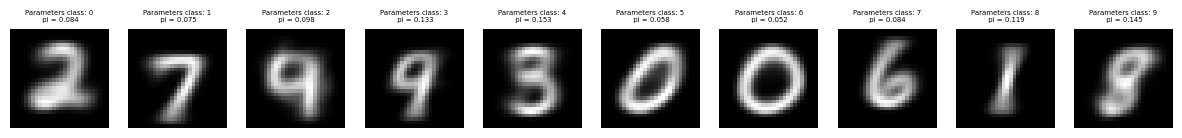

In [33]:
def sample_labels(labels, epochs=100, K=None, mu=None, pi=None, true_pi_init=False):
    if K is None: K = len(labels)
    print('-'*60+'\nTraining EM on labels {} and number of clusters K = {}\n'.format(labels, K)+'-'*60+'\n')

    labels_idxs = np.isin(train_labels, labels)
    subset_train_labels = train_labels[labels_idxs]
    subset_train_data = bin_train_data[labels_idxs]

    pi_true = []
    for label in labels:
        n_labels = np.isin(train_labels, label)
        pi_true.append(n_labels.sum())
    #print('True mixing coefficients: {}'.format(np.array(pi_true)/np.array(pi_true).sum()))
    if true_pi_init: pi = np.array(pi_true)
    
    print('\nTraining Progress')
    gamma, mu, pi = EM(X=subset_train_data, K=K, max_iter=epochs, mu=mu, pi=pi)

    fig, ax = plt.subplots(nrows=1, ncols=K, figsize=(15, 15), dpi=100)
    for i in range(K):
        ax[i].imshow(mu[i].reshape(28,28), cmap='gray')
        #print(i)
        ax[i].set_title('Parameters class: {}\n pi = {:0.3f}'.format(i, pi[i]), fontsize=K**(-1)//0.02)
        ax[i].axis('off')
    plt.show()

sample_labels([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Сробуємо згенерувати, наприклад, 2 6 7 9 для семи кластерів і подивитися що буде

------------------------------------------------------------
Training EM on labels [2, 6, 7, 9] and number of clusters K = 7
------------------------------------------------------------

True mixing coefficients: [0.24732254 0.2456621  0.26006642 0.24694894]

Training Progress
Epoch [  10/ 100] | delta mu: 0.2436 | delta pi: 0.0088
Epoch [  20/ 100] | delta mu: 0.2081 | delta pi: 0.0030
Epoch [  30/ 100] | delta mu: 0.0493 | delta pi: 0.0009
Epoch [  40/ 100] | delta mu: 0.0433 | delta pi: 0.0004
Epoch [  50/ 100] | delta mu: 0.0049 | delta pi: 0.0002
Epoch [  60/ 100] | delta mu: 0.0009 | delta pi: 0.0000

Converged at iteration 60.


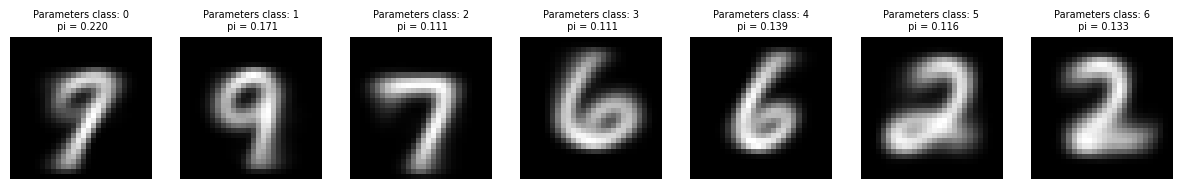

In [17]:
K=7
sample_labels(labels=[2, 6, 7, 9], K=K)